In [2]:
import warnings; warnings.simplefilter('ignore')
import os, shutil, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium 
import seaborn as sns
import tensorflow as tf

from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
data=pd.read_csv('Master Data Base.csv')

In [4]:
data

,Unnamed: 0,IATA,OACI,Date,Year,Month,Day,Hour,H Vsby,V Vsby,Temperature,Wind,Rain,Fog-Brume,Thunder,Op constraint,% Fog Occurrence,H Vsby (miles),V Vsby (ft),Airport Type_0,Airport Type_1,Airport Type_2,Avaliable H Vsby,Avaliable V Vsby,H Vsby t-1,V Vsby t-1,Temperature t-1,Wind t-1,H Vsby t-2,V Vsby t-2,Temperature t-2,Wind t-2,H Vsby t-3,V Vsby t-3,Temperature t-3,Wind t-3
0,0,ADZ,SKSP,2015-01-01 07:00:00,2015,1,1,7,6.21,1700.0,27.0,9.0,0,0,0,0,1.0,1.43,500,1,0,0,1,1,6.21,1700.0,27.0,9.0,6.21,1700.0,27.0,8.0,6.21,1700.0,27.0,8.0
1,1,ADZ,SKSP,2015-01-01 08:00:00,2015,1,1,8,6.21,1700.0,28.0,8.0,0,0,0,0,0.0,1.43,500,1,0,0,1,1,6.21,1700.0,27.0,9.0,6.21,1700.0,27.0,9.0,6.21,1700.0,27.0,8.0
2,2,ADZ,SKSP,2015-01-01 09:00:00,2015,1,1,9,6.21,1700.0,28.0,10.0,0,0,0,0,0.0,1.43,500,1,0,0,1,1,6.21,1700.0,28.0,8.0,6.21,1700.0,27.0,9.0,6.21,1700.0,27.0,9.0
3,3,ADZ,SKSP,2015-01-01 10:00:00,2015,1,1,10,6.21,1700.0,29.0,11.0,0,0,0,0,0.0,1.43,500,1,0,0,1,1,6.21,1700.0,28.0,10.0,6.21,1700.0,28.0,8.0,6.21,1700.0,27.0,9.0
4,4,ADZ,SKSP,2015-01-01 11:00:00,2015,1,1,11,6.21,1700.0,29.0,11.0,0,0,0,0,0.0,1.43,500,1,0,0,1,1,6.21,1700.0,29.0,11.0,6.21,1700.0,28.0,10.0,6.21,1700.0,28.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604842,604842,VUP,SKVP,2020-09-30 09:00:00,2020,9,30,9,6.21,1000.0,26.0,6.0,0,0,0,0,1.0,1.55,454,1,0,0,1,1,6.21,1000.0,24.0,6.0,6.21,2000.0,33.0,8.0,6.21,2000.0,33.0,11.0
604843,604843,VUP,SKVP,2020-09-30 10:00:00,2020,9,30,10,6.21,1000.0,29.0,7.0,0,0,0,0,1.0,1.55,454,1,0,0,1,1,6.21,1000.0,26.0,6.0,6.21,1000.0,24.0,6.0,6.21,2000.0,33.0,8.0
604844,604844,VUP,SKVP,2020-09-30 11:00:00,2020,9,30,11,6.21,1500.0,28.0,8.0,0,0,0,0,0.0,1.55,454,1,0,0,1,1,6.21,1000.0,29.0,7.0,6.21,1000.0,26.0,6.0,6.21,1000.0,24.0,6.0
604845,604845,VUP,SKVP,2020-09-30 13:00:00,2020,9,30,13,6.21,1500.0,31.0,7.0,0,0,0,0,0.0,1.55,454,1,0,0,1,1,6.21,1500.0,28.0,8.0,6.21,1000.0,29.0,7.0,6.21,1000.0,26.0,6.0


In [5]:
#The user should modify manually the IATA codes for the specifics airports that will be modeled
Airports=['ADZ','BAQ','BOG','BGA','CLO','CTG','CUC','LET','MDE','MTR','PEI','RCH','SMR','VUP']
#Airports=['BOG']
Variables=['V Vsby', 'H Vsby']

183/183 [==============================] - 1s 3ms/step - loss: 0.4269 - mean_absolute_error: 0.2666


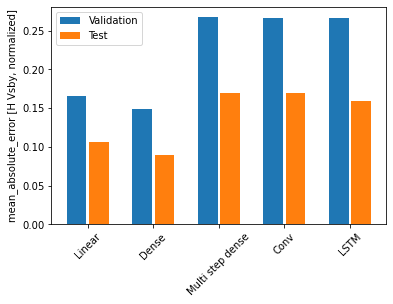

In [6]:
for j in range (0,len(Variables)):
    Variable=Variables[j]
    val_performance = {}
    performance = {}

###################### Loop to go across the airports of interest ############################################## 
    for i in range (0,len(Airports)):
        Airport=Airports[i]
        val_performance = {}
        performance = {}

###################### Manipulates and Normalizes the data ################################################### 

#Generates a new Dataset, containing only the airport code and the numeric variables regarding the metereological variables
        data_forecasting=data[['IATA','H Vsby','V Vsby', 'Temperature', 'Wind', 'Rain', 'Fog-Brume', 'Thunder']]

#Generates a Function to filter the dataset only for the specific airport that will be modeled
        def data_airport(str_airport):
            df_airport_2=data_forecasting[data_forecasting['IATA']==str_airport]    
            return df_airport_2

#Names the new data set df and drops the IATA code column, as it will not be included in the model
        df=data_airport(Airport)

        df.drop('IATA',
          axis='columns', inplace=True)


# Splits the data in Training, Validation and Test with a 0.7, 0.1 and 0.2 percentages
        column_indices = {name: i for i, name in enumerate(df.columns)}
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]


#Defines the number of features that will be included in  the model, as the total number of columns in the new df
        num_features = df.shape[1]

#Normalizes the 3 datasets, taking into account the training dataset mean and std
        train_mean = train_df.mean()
        train_std = train_df.std()

        train_df = (train_df - train_mean) / train_std
        val_df = (val_df - train_mean) / train_std
        test_df = (test_df - train_mean) / train_std



################ Defines the classes and Functions that will be used to build the Models ###########################


#Generates the class WindowGenerator, that will help defining the timestep that will be used in the model
        class WindowGenerator():
    #The first function within the class is to instantiate and define the variables entered as input
          def __init__(self, input_width, label_width, shift,
                       train_df=train_df, val_df=val_df, test_df=test_df,
                       label_columns=None):
    # Stores the raw data from the dataset
            self.train_df = train_df
            self.val_df = val_df
            self.test_df = test_df
    
    # Work out the label and the column indices, depending on the input parameters
            self.label_columns = label_columns
            if label_columns is not None:
              self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                                   enumerate(train_df.columns)}

    # Work out the window parameters.
            self.input_width = input_width
            self.label_width = label_width
            self.shift = shift

            self.total_window_size = input_width + shift

            self.input_slice = slice(0, input_width)
            self.input_indices = np.arange(self.total_window_size)[self.input_slice]

            self.label_start = self.total_window_size - self.label_width
            self.labels_slice = slice(self.label_start, None)
            self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    #This functions returns the Total Window Size, the Input and Label Indices and the Label column name
          def __repr__(self):
            return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])


#Defines a function to split the data sets according to the Window Type defined previously
        def split_window(self, features):
    #The input variables will be those that will not be predicted
          inputs = features[:, self.input_slice, :]
    #The label variables will be those that will be predicted
          labels = features[:, self.labels_slice, :]
          if self.label_columns is not None:
        #In case there is more than one label variable, this for stacks all of them
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

    #Defines the shapes for the input and the label variables
          inputs.set_shape([None, self.input_width, None])
          labels.set_shape([None, self.label_width, None])

    #Returns the input and the labels  
          return inputs, labels

        WindowGenerator.split_window = split_window



#Plot Function
        def plot(self, model=None, plot_col=Variable, max_subplots=3):
#Defines the input and the label variables
          inputs, labels = self.example
#Defines the plot size, plotting columns and maximum number of subplots that will be displayed
          plt.figure(figsize=(12, 8))
          plot_col_index = self.column_indices[plot_col]
          max_n = min(max_subplots, len(inputs))
#Plots a line with the measures for the label variable across the different timesteps
          for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue
#Plots a scatter with the exact measures for each timestep for the label variable
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
#If the is a model already defined, plots the predictions made for each timestep
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

          plt.xlabel('Time [h]')

        WindowGenerator.plot = plot


#This function will create the dataset in the TF format
        def make_dataset(self, data):
#Starting from a Pandas df, it converts it to a Numpy array of type float32
          data = np.array(data, dtype=np.float32)
#Uses the method tf.keras.preprocessing.timeseries_dataset_from_array to convert from np array to tf dataset
          ds = tf.keras.preprocessing.timeseries_dataset_from_array(
#The data will be the one inputed as a parameter in the function
              data=data,
# No Target defined
              targets=None,
#Defines the sequence lenght as the Total size of the Window 
              sequence_length=self.total_window_size,
#Defines the time between timestep as 1      
              sequence_stride=1,
#Defines to shuffle the output samples, intead of showing them in chronological order
              shuffle=True,
#Defines the batch that will be used to run the model. The predefined Batch will be 32. The last one will
#probably not be the same size
              batch_size=32,)
#Retunrs a mapping of the tf dataset generated
          ds = ds.map(self.split_window)

          return ds
        WindowGenerator.make_dataset = make_dataset


#Defines as properties of the Class, Functions for generating the Trainig, Validation and Test datasets 
#using the make_dataset function
        @property
        def train(self):
          return self.make_dataset(self.train_df)

        @property
        def val(self):
          return self.make_dataset(self.val_df)

        @property
        def test(self):
          return self.make_dataset(self.test_df)

#Gives this for using it as an example dataset, in case you don want to generate a subset of the previous dataframes
#In this case, the example will be used for plotting a random Window from the training dataset
        @property
        def example(self):
          """Get and cache an example batch of `inputs, labels` for plotting."""
          result = getattr(self, '_example', None)
          if result is None:
    # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
    # And cache it for next time
            self._example = result
          return result

        WindowGenerator.train = train
        WindowGenerator.val = val
        WindowGenerator.test = test
        WindowGenerator.example = example


####################### Windowing for the Models ###############################################################

#Defines a simple Window, correspondig to a 1 Input and 1 Label variable.
#Defines the Label Variable, depending on the Variable defined at the begging of the analysis

        single_step_window = WindowGenerator(
            input_width=1, label_width=2, shift=1,
            label_columns=[Variable])
        single_step_window

#Generates a new, Wider Window correponding to a 24 Hours period, with a label widht of 24 hours and 1 
#and 1 timestep as Shift
        wide_window = WindowGenerator(
            input_width=24, label_width=24, shift=1,
            label_columns=[Variable])

################################## Linear Model ####################################################################
        linear = tf.keras.Sequential([
            tf.keras.layers.Dense(units=1)
        ])

#Defines the Max Number of Epochs for the model as 20
        MAX_EPOCHS = 20

#Defines a generic funtion of Compiling and Fiting the model. It is define so, that
#it can be used for any type of model. The inputs will be the model to compile and fit, the Window used and the
#Patience parameter for the Earlt Stop callback from keras
        def compile_and_fit(model, window, patience=2):
#Defines the Early Stopping to avoid Overfitting
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=patience,
                                                            mode='min')
#Compiles the model
          model.compile(loss=tf.losses.MeanSquaredError(),
                        optimizer=tf.optimizers.Adam(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

#Fits the model and stores the data in an objet called history
          history = model.fit(window.train, epochs=MAX_EPOCHS,
                              validation_data=window.val,
                              callbacks=[early_stopping])
          return history

        print('Linear Model:')
#Compiles and Fits the linear model with the single step window
        history = compile_and_fit(linear, single_step_window)

        import IPython
#Deletes the results for the 20 Epochs and only sisplays the last Epoch result
        IPython.display.clear_output()

#Stores in the Variables the Performance for the Validation and the Test Performance
        val_performance['Linear'] = linear.evaluate(single_step_window.val)
        performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


###################### Dense #####################################################################################

#Defines the Dense Model and Compiles and Fit for the Single Step WIndow
#The Dense model defines 2 intermediate layers with 64 neurons each, with a relu activation function

        dense = tf.keras.Sequential([
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])

        print('Dense Model:')
#Compiles and fits the model
        history = compile_and_fit(dense, single_step_window)

#Deletes the results for the 20 Epochs and only sisplays the last Epoch result
        IPython.display.clear_output()

#Stores the performances
        val_performance['Dense'] = dense.evaluate(single_step_window.val)
        performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


################# Multi Step Model##############################################################################

#The previous Models predicts the following hour, taking into account only the previous hour. in this Model
#You can define the number of previous hours that the model will take into account for predicting. In this case, 3
        CONV_WIDTH = 3

#Defines a new Window depending on the new step defined
        conv_window = WindowGenerator(
            input_width=CONV_WIDTH,
            label_width=1,
            shift=1,
            label_columns=[Variable])

        conv_window

#Define the new model as the dense model, but with the new Step
        multi_step_dense = tf.keras.Sequential([
            # Shape: (time, features) => (time*features)
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=1),
            # Add back the time dimension.
            # Shape: (outputs) => (1, outputs)
            tf.keras.layers.Reshape([1, -1]),
        ])

        print('Dense Multi Step Model:')
#Compiles and fits the new Model
        history = compile_and_fit(multi_step_dense, conv_window)

#Deletes the results for the 20 Epochs and only Displays the last Epoch result
        IPython.display.clear_output()
#Stores the performances
        val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
        performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)



#################################Convolutional Model##############################################################

#Defines the new model including a Convolutional layer, which allows to inlude the the new Window for he prediction
#The first advantage is that now it is not necesarry to predict only using the last timestep
        conv_model = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters=32,
                                   kernel_size=(CONV_WIDTH,),
                                   activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=1),
        ])


        print('Convolutional Model:')
#Trains and Compiles the new model
        history = compile_and_fit(conv_model, conv_window)

#Cleans the results and store the performances
        IPython.display.clear_output()
        val_performance['Conv'] = conv_model.evaluate(conv_window.val)
        performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

#Generates new Windows according to the inputs required by the Convolutional model
        LABEL_WIDTH = 24
        INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
        wide_conv_window = WindowGenerator(
            input_width=INPUT_WIDTH,
            label_width=LABEL_WIDTH,
            shift=1,
            label_columns=[Variable])


##############################Recurrent Neural Model##############################################################

#Defines the new model with a recurrent layer. This models uses the results of each time step to retrofit the following 
#prediction
        lstm_model = tf.keras.models.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(32, return_sequences=True),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1)
        ])

        print('Recurrent Model:')
#Compiles and fits the new model
        history = compile_and_fit(lstm_model, wide_window)

#Cleans and stores the performances
        IPython.display.clear_output()
        val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
        performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


####################Evaluates the performance for all the models with the normlized measures#######################

        x = np.arange(len(performance))
        width = 0.3
        metric_name = 'mean_absolute_error'
        metric_index = lstm_model.metrics_names.index('mean_absolute_error')
        val_mae = [v[metric_index] for v in val_performance.values()]
        test_mae = [v[metric_index] for v in performance.values()]

        ylabel_plot='mean_absolute_error ['+Variable+', normalized]'
        plt.ylabel(ylabel_plot)
        plt.bar(x - 0.17, val_mae, width, label='Validation')
        plt.bar(x + 0.17, test_mae, width, label='Test')
        plt.xticks(ticks=x, labels=performance.keys(),
                   rotation=45)
        _ = plt.legend()
        plt.show()

########################### Saves the Performance Array and Plots ########################################################
        from datetime import datetime
        now = datetime.now() # current date and time
        year = now.strftime("%Y")
        year_0=year[0]
        year_1=year[1]
        year=year_0+year_1
        month = now.strftime("%m")
        day = now.strftime("%d")
        date_path=year+month+day
        date_path
        
        path_Performance=date_path+' Performance/'
    
        import os
        if not os.path.exists(path_Performance):
            os.makedirs(path_Performance)
        if not os.path.exists(path_Performance+Airport+'/'):
            os.makedirs(path_Performance+Airport+'/')
        
        import csv
        performance_name=path_Performance+Airport+'/'+Variable+'.csv'
        with open(performance_name, 'w') as f:
            for key in performance.keys():
                f.write("%s,%s\n"%(key,performance[key]))


########################### Saves the best Performed Model ########################################################
        
        path_Models=date_path+' Models/'
    
        if not os.path.exists(path_Models):
            os.makedirs(path_Models)
        if not os.path.exists(path_Models+Airport+'/'):
            os.makedirs(path_Models+Airport+'/')

        Best_Model=min(performance, key=performance.get)
        model_name=path_Models+Airport+'/'+Variable+'.h5'


        if Best_Model=='Linear':
            linear.save(model_name)
        elif Best_Model=='Dense':
            dense.save(model_name)
        elif Best_Model == 'Multi step dense':
            multi_step_dense.save(model_name)
        elif Best_Model == 'Conv':
            conv_model.save(model_name)
        else:
            lstm_model.save(model_name)